# Feature evaluation

org: **D4G**  project: **BGCO**  task: **feature evaluation**

data: labeled (engage vs. static) dataset highlighting changes in member engagement (visits per week) between first and year of engagement

## Prep the environment

In [1]:
import pandas as pd  # used to manipulate dataframes
import numpy as np # used to manipulate series

import seaborn as sns  # needed for visualing
import matplotlib.pyplot as plt  # needed for visualing

## Data Wrangling

### Load Data

In [35]:
# read in the dataframe
df_001 = pd.read_csv("D4G_BGCO_Churn_Labeled_002.csv", encoding = "cp1252")

### Feature Evaluation

In [41]:
df_002 = df_001.drop(droplist_unique, axis = 1)  # features with no unique values removed

In [66]:
df_003 = df_002.drop(['member_identity', 'birth_year', 'age', 'city', 'active', 'd4g_valid_postal_code', 'checkin_avg'], axis = 1)  # redundant features

In [67]:
df_004 = df_003.drop(['member_number'], axis = 1)  # erroneous aggregation

In [68]:
df_005 = df_004.drop(droplist_missing, axis = 1)  # missing values exceed 20%

In [69]:
df_006 = df_005.drop(imbalance, axis = 1)  # where one value count > 85%

In [70]:
df = df_006

In [71]:
print("The training set has {0} rows and {1} columns".format(df.shape[0], df.shape[1]))

The training set has 2234 rows and 13 columns


### Feature Summary

Proposed
* total number of visits to clubhouse in y1 (find out if clubhouse is a factor)
* visits per week or month to clubhouse in y1 (find out if clubhouse is a factor)

Key
* d4g_member_id (primary key)

Behaviour
* label (target feature)
* member_fees_total
* total number of visits by member in y1
* visits grouped by fall or winter

Service
* first_year: the first year of engagement
* member_location: clubhouse visited

Characteristic
* Y1_Age: age at first_year
* age category
* sex
* postal_code (see Conditional Inclusions)
* d4g_school_id
* grade

Conditional Inclusions
* first_language (only 60% of the dataset) (missing data)
* postal_code (only 90% of the dataset) (missing data)
* d4g_valid_postal_code (only 85% of the dataset) (missing data) (more accurate?)


### Unique Values

Number of unique values, if 1 or less should be removed.

In [72]:
df.nunique()

d4g_member_id      2234
label                 2
first_year           10
member_location       9
postal_code        1162
sex                   2
d4g_school_id       180
grade                13
Y1_Age               19
checkin_total        39
age_category          5
fall_frac           172
winter_frac         172
dtype: int64

Create a list of columns with low unique value counts

In [73]:
droplist_unique = [i for i in df.columns if df[i].nunique('label') < 2]
droplist_unique  # from df_001

[]

### Erroneous Aggregation

Special case: Member numbers
* the duplicates in this feature seem to correspond to different members
* thus inclusion erroneously reduces variability, without adding qualifiers

In [17]:
duplicates = df.duplicated('member_number', keep = False)
df_duplicates = df[duplicates]
df_duplicates[['member_number','first_year', 'sex', 'Y1_Age']].sort_values(by = 'member_number').head(6)

KeyError: Index(['member_number'], dtype='object')

### Missing Values

How many features/attributes have missing values? Which ones?
* df_004 used to exclude if missing > 20%

In [48]:
print("A total of ", len(df.columns[df.isnull().any()]), "features have missing values")
print("They are:", df.columns[df.isnull().any()])

A total of  11 features have missing values
They are: Index(['postal_code', 'grade', 'first_language', 'second_language',
       'other_languages', 'member_since', 'last_renewal_date', 'camper',
       'camp_year', 'hear_about', 'family_identity'],
      dtype='object')


How many are missing?

In [49]:
miss = df.isnull().sum() #number of missing entries in each feature / number of total entries
miss = miss[miss > 0] # keep only those that are greater than "0 / number of total entries"
miss.sort_values(inplace=True) # sort by percentage ascending
miss # display

camper                  1
hear_about              1
camp_year               5
grade                  11
postal_code           251
member_since          485
first_language        836
last_renewal_date     914
family_identity      1678
second_language      2188
other_languages      2220
dtype: int64

What is the percentage of missing values?

In [50]:
miss = df.isnull().sum()/len(df) #number of missing entries in each feature / number of total entries
miss = miss[miss > 0] # keep only those that are greater than "0 / number of total entries"
miss.sort_values(inplace=True) # sort by percentage ascending
miss # display

camper               0.000448
hear_about           0.000448
camp_year            0.002238
grade                0.004924
postal_code          0.112355
member_since         0.217099
first_language       0.374217
last_renewal_date    0.409132
family_identity      0.751119
second_language      0.979409
other_languages      0.993733
dtype: float64

Visualising missing values

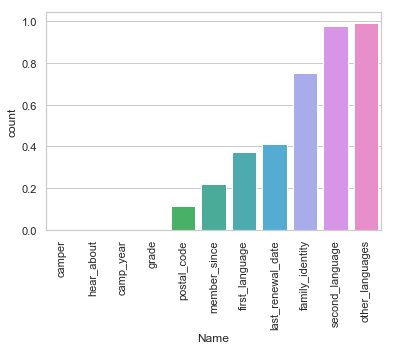

In [51]:
miss = miss.to_frame() # convert to a dataframe
miss.columns = ['count'] # rename the column as 'count'
miss.index.names = ['Name'] # rename index as 'Name'
miss['Name'] = miss.index # create a new column of the index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
plt.show()

Remove if exceeds 25%

In [52]:
droplist_missing = [i for i in df.columns if df[i].isnull().sum()/len(df[i]) > 0.2]
droplist_missing  # from df_004

['first_language',
 'second_language',
 'other_languages',
 'member_since',
 'last_renewal_date',
 'family_identity']

### Feature Balance

Create a smaller subset of 

In [56]:
balance_check = [i for i in df.columns if df[i].nunique() < 50]
df_balance_check = df[balance_check]

df_balance_check.nunique()

label               2
first_year         10
mem_type            2
member_location     9
province            3
sex                 2
grade              13
suspended           2
camper              2
camp_year           2
hear_about          2
Y1_Age             19
checkin_total      39
checkin_avg        39
age_category        5
dtype: int64

Define a function to remove columns that have a value count exceeding 90%

In [57]:
def imbalanced_features(df_to_check, threshold = 0.9):
    """
    Returns a list of columns where at least one value count exceeds threshold
    """
    
    df_to_output = df_to_check
    
    for h in df_to_check.columns:
        col_val_count = pd.value_counts(df_to_check[h].values, sort=False)  # returns value counts by column
        
        count = 0
        
        for i in col_val_count.values:
            if i / df_to_check.shape[0] > threshold:
                count += 1
        
        if count > 0:
            df_to_output = df_to_output.drop(h, axis = 1)
            
    list_to_output = df_to_check.drop(df_to_output.columns, axis = 1).columns
            
    return list_to_output

Use function to create list of imbalanced features

In [58]:
imbalance = imbalanced_features(df_balance_check, 0.85)
imbalance

Index(['mem_type', 'province', 'suspended', 'camper', 'camp_year',
       'hear_about'],
      dtype='object')

Update df by dropping imbalanced features

In [59]:
categorical_features = df_balance_check.drop(imbalance, axis = 1).columns

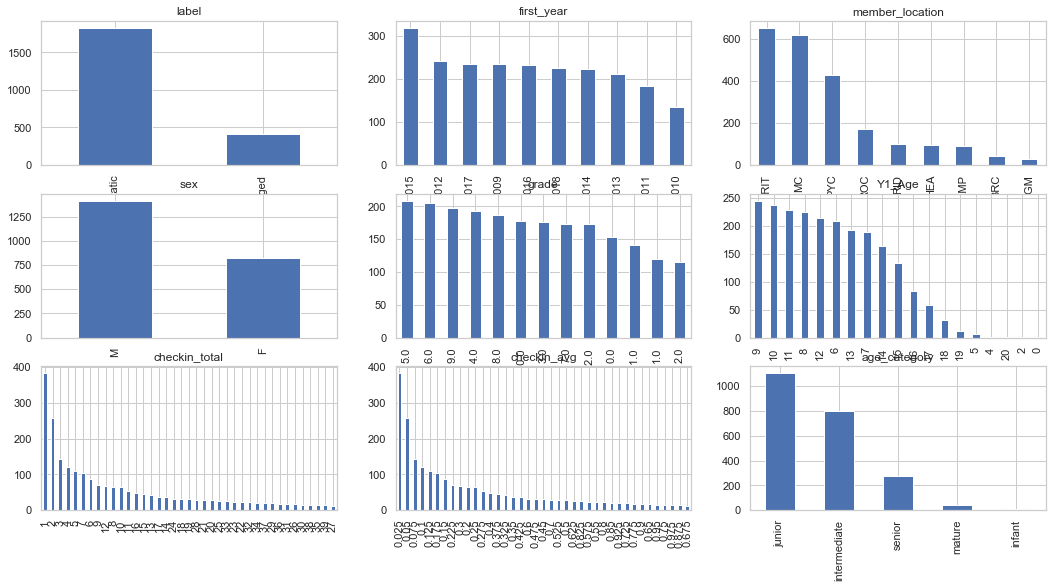

In [61]:
# plot parameters
ROWS, COLS = 3, 3  # set number of rows and columns for figures

fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 9))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)